## Set-Up the Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

# install pillow
# !pip uninstall -y Pillow
# !pip install Pillow==4.1.1

# # download and unzip dataset o train
# !wget http://images.cocodataset.org/zips/train2014.zip
# !mkdir train
# %cd /content/train
# !unzip -qq /content/train2014.zip
# %cd ..

#download model
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

# download helper code
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/transformer.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/experimental.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/utils.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/vgg.py

# download style image
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/images/mosaic.jpg

--2024-03-17 13:14:26--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M  50.3MB/s    in 11s     

2024-03-17 13:14:38 (48.0 MB/s) - ‘vgg16-00b39a1b.pth’ saved [553451520/553451520]

--2024-03-17 13:14:38--  https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4660 (4.6K) [text/plain]
Saving to: ‘transformer.py’

transformer.py

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


## Import Relevant Packages

In [ ]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg
import transformer
import experimental
import utils
import re
import wandb
import pickle
from google.colab.patches import cv2_imshow

## Utils

In [ ]:

def dump_data(data, file_path: str) -> None:
    """
    Serialize and dump the data to a binary file using pickle.

    Parameters:
    - data: Any Python object to be serialized and saved.
    - file_path (str): The path to the file where data will be saved.
    """
    assert isinstance(file_path, str), "file_path must be a string"
    try:
        with open(file_path, 'wb') as file:
            pickle.dump(data, file)

    except (IOError, FileNotFoundError, PermissionError) as e:
        print(f"Error during dump_data: {e}")

def load_data_from_path(file_path: str):
    """
    Load and deserialize data from a binary file using pickle.

    Parameters:
    - file_path (str): The path to the file from which data will be loaded.

    Returns:
    - loaded_data: The deserialized data.
    """
    assert isinstance(file_path, str), "file_path must be a string"

    try:
        # Load the data from the file
        with open(file_path, 'rb') as file:
            loaded_data = pickle.load(file)


        return loaded_data

    except (IOError, FileNotFoundError, PermissionError, pickle.PickleError) as e:
        print(f"Error during load_data_from_path: {e}")
        return None

In [ ]:
def connect_to_wandb(project: str,
                    run_id_path: str,
                    run_name: str) -> None:

    # Additional runtime checks if needed
    assert isinstance(project, str), "project_name should be a string"
    assert isinstance(run_id_path, str), "run_id_path should be a string"
    assert isinstance(run_name, str), "run_name should be a string"

    run_id = None
    resume = None


    if not os.path.exists(run_id_path):
      with open(run_id_path, 'wb'):
        pass
      run_ids = dict()
    else:
      run_ids = load_data_from_path(run_id_path)


    if run_name in run_ids.keys():
        run_id = run_ids[run_name]
        resume = "must"




    wandb.init(project = project, name = run_name, id = run_id, resume = resume)

    # If the run is created for the first time, we will associate the run id to the run name
    # We want that this file could not be directly accessed by the user
    not_exist_run_name = (os.path.exists(run_id_path)) \
                    and (run_name not in run_ids.keys()) \
                    or (not os.path.exists(run_id_path))

    if not_exist_run_name:
        run_ids[run_name] = wandb.run.id
        dump_data(run_ids, run_id_path)

In [ ]:
def get_file_with_largest_number(folder_path):
    # Get list of files in folder
    files = os.listdir(folder_path)

    # If the folder is empty, return None
    if not files:
        return None

    # Sort files based on numbers in filenames
    sorted_files = sorted(files, key=lambda x: int(re.search(r'\d+', x).group()), reverse=True)

    # Return the file with the largest number
    return sorted_files[0]

In [ ]:
def get_subfolders(folder_path):
    """
    Retrieves the paths of all subfolders within a given folder.

    Args:
        folder_path (str): The path to the folder.

    Returns:
        list: A list containing the paths of all subfolders.
    """
    subfolder_paths = []

    # Get list of all files and directories within the folder
    entries = os.listdir(folder_path)
    # Iterate through each entry
    for entry in entries:
        # Construct the full path
        full_path = os.path.join(folder_path, entry)
        subfolder_paths.append(full_path)



    return subfolder_paths

In [ ]:
def delete_files_with_unwanted_extensions(folder_path):
    # Define allowed extensions
    allowed_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']

    # Get list of files in folder
    files = os.listdir(folder_path)

    # Iterate through each file
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        # Check if the file is not a directory and has an extension
        if os.path.isfile(file_path) and os.path.splitext(file_name)[1].lower() not in allowed_extensions:
            # Delete the file
            os.remove(file_path)

## Configurations

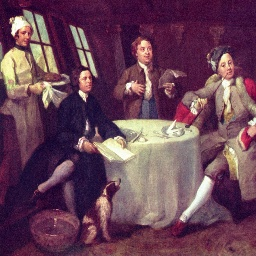

In [ ]:
PROJECT_NAME = "Neural Style Transfer"
# GLOBAL SETTINGS
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "/content/drive/MyDrive/ISIMA/GAN Project/Dataset/dataset/Neural Style Transfer/"
NUM_EPOCHS = 20
STYLE_IMAGE_PATH = "/content/drive/MyDrive/ISIMA/GAN Project/Dataset/dataset/r256x256/25614876.jpg"
# subfolders = get_subfolders(STYLE_IMAGE_PATH)
# idx = 0
# STYLE_IMAGE_PATH = subfolders[idx]

BATCH_SIZE = 4
CONTENT_WEIGHT = 17
STYLE_WEIGHT = 50
TV_WEIGHT = 1e-6
ADAM_LR = 0.001
SAVE_MODEL_PATH = "/content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/checkpoints/"
SAVE_IMAGE_PATH = "/content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
CHECKPOINT_PATH = os.path.join(SAVE_MODEL_PATH, "checkpoint_a3000.pth")

# Wandb configurations

# Don'tchange these ones
RUN_ID_PATH = "/content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/configs/run_ids.pkl"
WANDB_API = "50ec2df756bf2e8a273dc36f5a363b8e445c743f"

# Change only this one according to the name of the run (the same as the name of the model, all the run names used in the project should be different)
RUN_NAME = "TransformerResNextNetwork_Pruned03"

image = cv2.imread(STYLE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2_imshow(image)
cv2.imwrite("/content/style_image.png", image)

STYLE_IMAGE_PATH = "/content/style_image.png"

IDX = "c"

## Run Wand

In [ ]:
wandb.login(key=WANDB_API)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
connect_to_wandb(PROJECT_NAME, RUN_ID_PATH, RUN_NAME)

wandb: Currently logged in as: b_mokhtari (billal-mokhtari). Use `wandb login --relogin` to force relogin


## Model Training

In [ ]:
delete_files_with_unwanted_extensions(os.path.join(DATASET_PATH, "img_align_celeba"))

OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/ISIMA/GAN Project/Dataset/dataset/Neural Style Transfer/img_align_celeba'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


========Epoch 1/21========
========Iteration 1/186120========
	Content Loss:	3535569.25
	Style Loss:	607946.81
	Total Loss:	4143516.00
Time elapsed:	8.144697666168213 seconds
Saved TransformerNetwork checkpoint file at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/checkpoints/checkpoint_c0.pth


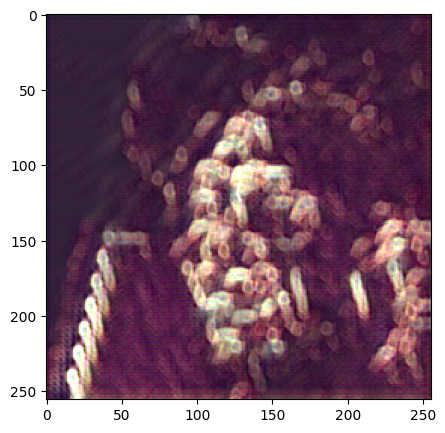

Saved sample tranformed image at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/images/sample0_c0.png
========Iteration 501/186120========
	Content Loss:	3536546.00
	Style Loss:	611807.12
	Total Loss:	4148355.69
Time elapsed:	803.1494216918945 seconds
Saved TransformerNetwork checkpoint file at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/checkpoints/checkpoint_c500.pth


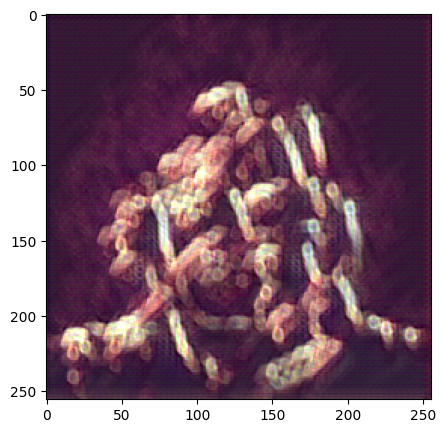

Saved sample tranformed image at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/images/sample0_c500.png
========Iteration 1001/186120========
	Content Loss:	3535209.25
	Style Loss:	608036.44
	Total Loss:	4143247.76
Time elapsed:	1573.515958070755 seconds
Saved TransformerNetwork checkpoint file at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/checkpoints/checkpoint_c1000.pth


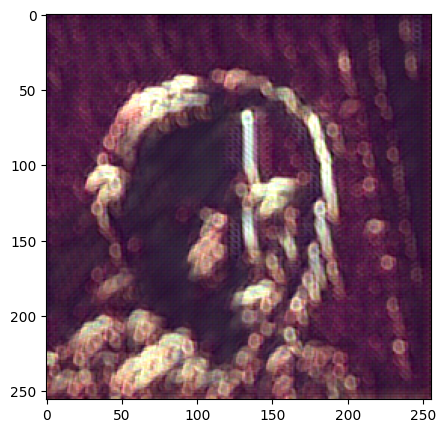

Saved sample tranformed image at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/images/sample0_c1000.png
========Iteration 1501/186120========
	Content Loss:	3533776.00
	Style Loss:	604913.00
	Total Loss:	4138688.87
Time elapsed:	2392.908139705658 seconds
Saved TransformerNetwork checkpoint file at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/checkpoints/checkpoint_c1500.pth


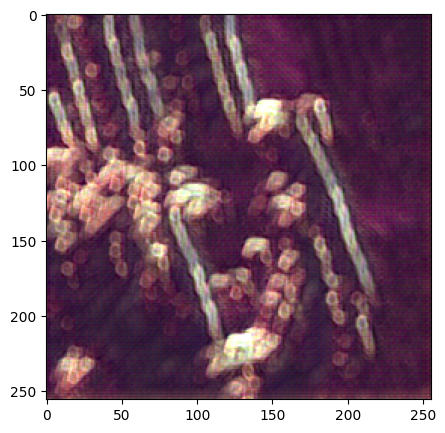

Saved sample tranformed image at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/images/sample0_c1500.png
========Iteration 2001/186120========
	Content Loss:	3531986.75
	Style Loss:	601435.62
	Total Loss:	4133419.92
Time elapsed:	3199.475216150284 seconds
Saved TransformerNetwork checkpoint file at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/checkpoints/checkpoint_c2000.pth


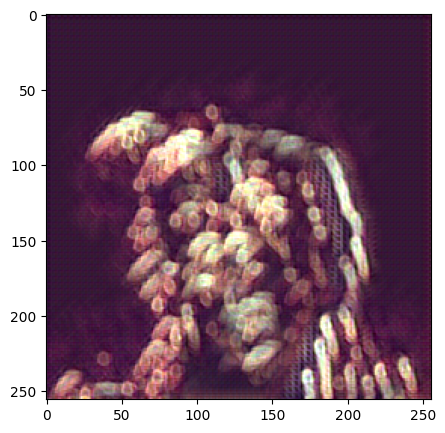

Saved sample tranformed image at /content/drive/MyDrive/ISIMA/GAN Project/Code/Neural Style Transfer/outputs/3. TransformerResNextNetwork_Pruned03/images/sample0_c2000.png


In [ ]:
def train():
    # Seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and Dataloader
    transform = transforms.Compose([
        transforms.Resize((TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)),
        # transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Load networks
    #TransformerNetwork = transformer.TransformerNetwork().to(device)
    TransformerNetwork = experimental.TransformerResNextNetwork_Pruned(0.3).to(device)
    VGG = vgg.VGG16('/content/vgg16-00b39a1b.pth').to(device)

    # Get Style Features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    imagenet_mean = torch.tensor([103.939, 116.779, 123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    style_image = utils.load_image(STYLE_IMAGE_PATH)
    style_tensor = utils.itot(style_image).to(device)
    style_tensor = style_tensor.add(imagenet_neg_mean)
    B, C, H, W = style_tensor.shape
    style_features = VGG(style_tensor.expand([BATCH_SIZE, C, H, W]))
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = utils.gram(value)

    if CHECKPOINT_PATH is not None:
      TransformerNetwork.load_state_dict(torch.load(CHECKPOINT_PATH))

    # Optimizer settings
    optimizer = optim.Adam(TransformerNetwork.parameters(), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()
    for epoch in range (1, NUM_EPOCHS+1):
        print("========Epoch {}/{}========".format(epoch, NUM_EPOCHS+1))
        for batch_id, (content_batch, _) in enumerate(train_loader):
            # Current Batch size in case of odd batches
            curr_batch_size = content_batch.shape[0]

            # Zero-out Gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = TransformerNetwork(content_batch)
            content_features = VGG(content_batch.add(imagenet_neg_mean))
            generated_features = VGG(generated_batch.add(imagenet_neg_mean))

            # Content Loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(content_features['relu2_2'], generated_features['relu2_2'])
            batch_content_loss_sum += content_loss

            # Style Loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss

            # Total Loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backprop and Weight Update
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_"+IDX+ str(batch_count-1) + ".pth"
                torch.save(TransformerNetwork.state_dict(), checkpoint_path)
                print("Saved TransformerNetwork checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0)
                sample_image = utils.ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_"+IDX+ str(batch_count-1) + ".png"
                utils.saveimg(sample_image, sample_image_path)
                utils.show(sample_image)
                print("Saved sample tranformed image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_content_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)

                # Log the losses
                wandb.log({"batch content loss": batch_content_loss_sum/batch_count})
                wandb.log({"batch style loss": batch_style_loss_sum/batch_count})
                wandb.log({"batch total loss": batch_total_loss_sum/batch_count})

            # Iterate Batch Counter
            batch_count+=1

    stop_time = time.time()
    # Print loss histories
    print("Done Training the Transformer Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history)
    print("========Style Loss========")
    print(style_loss_history)
    print("========Total Loss========")
    print(total_loss_history)

    # Save TransformerNetwork weights
    TransformerNetwork.eval()
    TransformerNetwork.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving TransformerNetwork weights at {}".format(final_path))
    torch.save(TransformerNetwork.state_dict(), final_path)
    print("Done saving final model")

train()